# Regression with Orbit

In this notebook, we want to demonstartate how to use the different arguments in the model classes (DLT) to realize different setups for the regressors. Those could be very useful in practice when tuning the models. Here includes two example, one with the icliams dataset and one for the simulation data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.simulation import make_regression
from orbit.constants.palette import QualitativePalette

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from pylab import rcParams

rcParams['figure.figsize'] = 14, 8
plt.style.use('fivethirtyeight')

%matplotlib inline

# Will iclaims Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) from Jan 2010 - June 2018. This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In order to use this data to nowcast the US unemployment claims during COVID-19 period, we extended the dataset to Jan 2021 and added the [&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

In [65]:
# load data
df = load_iclaims(end_date='2021-01-03')

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [66]:
# standardize the job claims by median
m = df['claims'].median()
df['claims'] = df['claims']/m

# log transfer
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [67]:
df.tail(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
570,2020-12-06,1.137568,2.086280,0.164040,-0.216098,3663.459961,23.309999
571,2020-12-13,1.122226,2.086280,0.238148,-0.216098,3709.409912,21.570000
572,2020-12-20,1.046184,2.240431,0.432304,-0.473927,3703.060059,21.530001
573,2020-12-27,1.013264,2.469273,0.144622,-0.416768,3756.070068,22.750000
574,2021-01-03,1.100939,2.469273,0.083997,-0.216098,3824.679932,21.559999


We can see form the plot below, there are seasonlity trend and as well as a huge changpoint due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

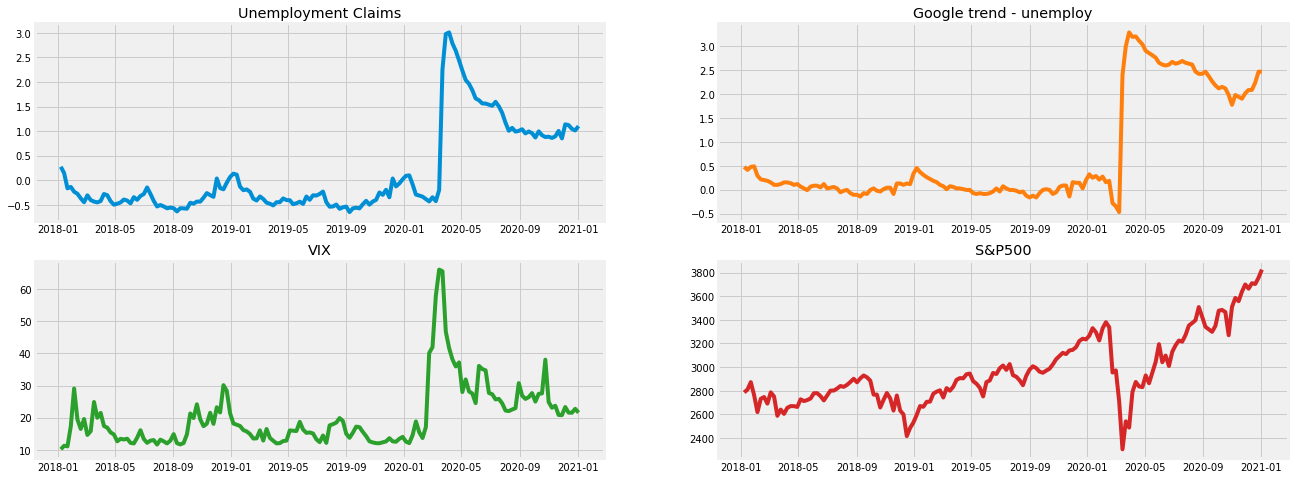

In [119]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

In [68]:
# split the dataset
# only use the data after 2018 as we observed from above chart that it has the more clear relationship between trend.unemploy and claims
df = df[df['week'] > '2018-01-01'].reset_index(drop=True)

test_size = 26
train_df = df[:-test_size]
test_df = df[-test_size:]

## Without Regression

We will use the DLT models here to compare the model performance without vs. with regression.

In [69]:
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    num_warmup=4000
)

In [70]:
%%time
dlt.fit(df=train_df)

CPU times: user 157 ms, sys: 121 ms, total: 278 ms
Wall time: 12 s


In [71]:
predicted_df = dlt.predict(df=test_df)

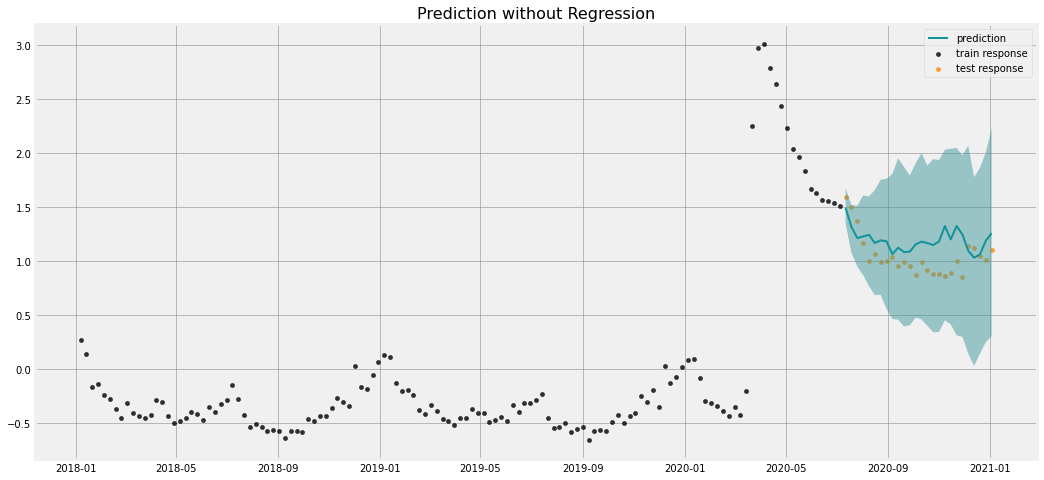

In [72]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction without Regression')

## With Regression

The regressor columns can be supplied via argument `regressor_col`. Their signs can be specified via `regressor_sign`, with values either '=' (regular, no restriction) or '+' (positive). These two lists should be of the same lenght. The default values of `regressor_sign` is all '='.

Also, note that in general, a better performance can be acheived in regressions with `infer_method=mcmc` due to potential high dimensional distributions of parameters. We will use `mcmc` as sample method in following examples.

### Regressor with the sign

In [86]:
REGRESSOR_COL = ['trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix']
dlt_reg = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '=', '-', '+'], 
    seasonality=52,
    seed=8888,
    num_warmup=4000
)
dlt_reg.fit(df=train_df)

The estimated regressor coefficients can be retrieved via `.aggregated_posteriors`.

In [87]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.110526
1,trend.filling,Positive,0.213873
2,vix,Positive,0.001621
3,sp500,Negative,-0.000128
4,trend.job,Regular,0.042517


In [88]:
predicted_df_reg = dlt_reg.predict(test_df)

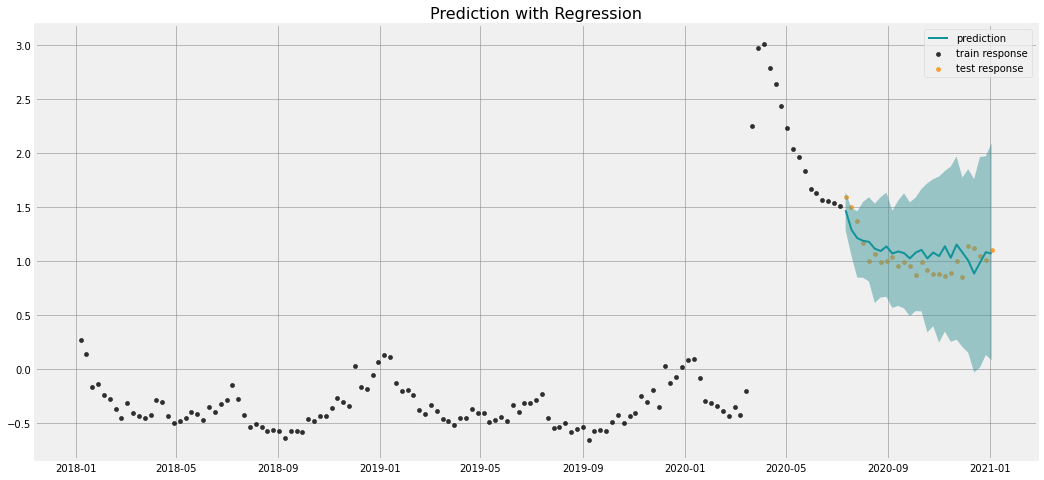

In [89]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression')

After adding the regressor, prediction results are more closer to the real response compared to without using regression. 

### Adjust pirors for regressor beta and standard deviation

In the model, it is assumed $$\beta \sim Gaussian(\beta_{prior}, \sigma_{prior})$$

The default values for $\beta_{prior}$ and $\sigma_{prior}$ are 0 and 1, respectively.

Users could adjust them via arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same lenght as `regressor_col`.

In [109]:
dlt_reg_adjust = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '=', '-', '+'], 
    regressor_sigma_prior=[0.1]*5,
    seasonality=52,
    seed=8888,
    num_warmup=4000,
    num_sample=1000
)
dlt_reg_adjust.fit(df=train_df)

One can notice the significant changes in the estimted coefficients by using different priors.

In [110]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.086171
1,trend.filling,Positive,0.112730
2,vix,Positive,0.001550
3,sp500,Negative,-0.000137
4,trend.job,Regular,0.002976


In [111]:
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

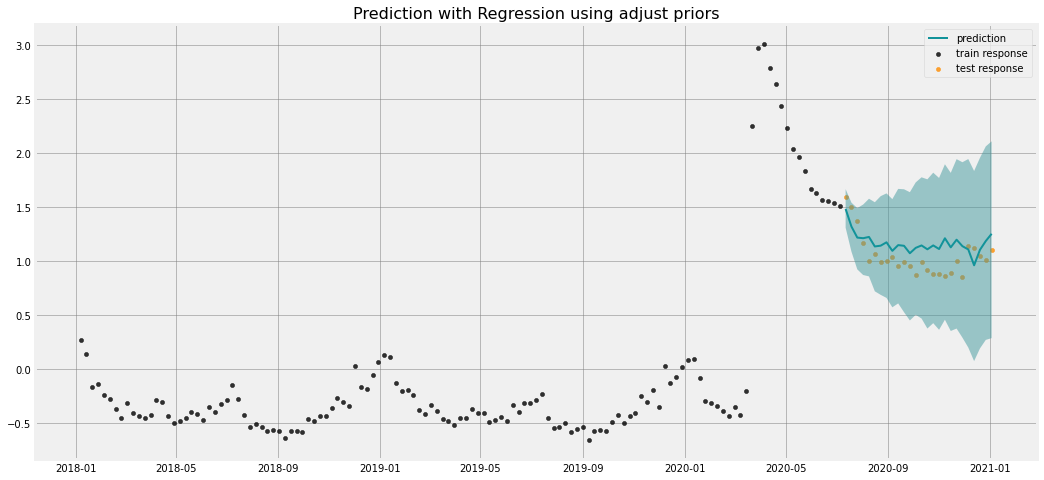

In [112]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using adjust priors')

### Use data-driven sigma for each coefficients

Instead of using fixed standard deviations for regressors, a hyperprior can be assigned to them, i.e.
$$\sigma_\beta \sim \text{Half-Cauchy}(0, \text{ridge_scale})$$

This can be done by setting `regression_penalty="auto_ridge"`.  Notice there is hyperprior `auto_ridge_scale` for tuning with a default of `0.5`.

In [105]:
dlt_reg_ridge = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '=', '-', '+'],
    seasonality=52,
    regression_penalty="auto_ridge",
    auto_ridge_scale=0.5,
    seed=8888,
    num_warmup=4000,
    num_sample=1000
)
dlt_reg_ridge.fit(df=train_df)

In [107]:
predicted_df_reg_ridge = dlt_reg_ridge.predict(test_df)

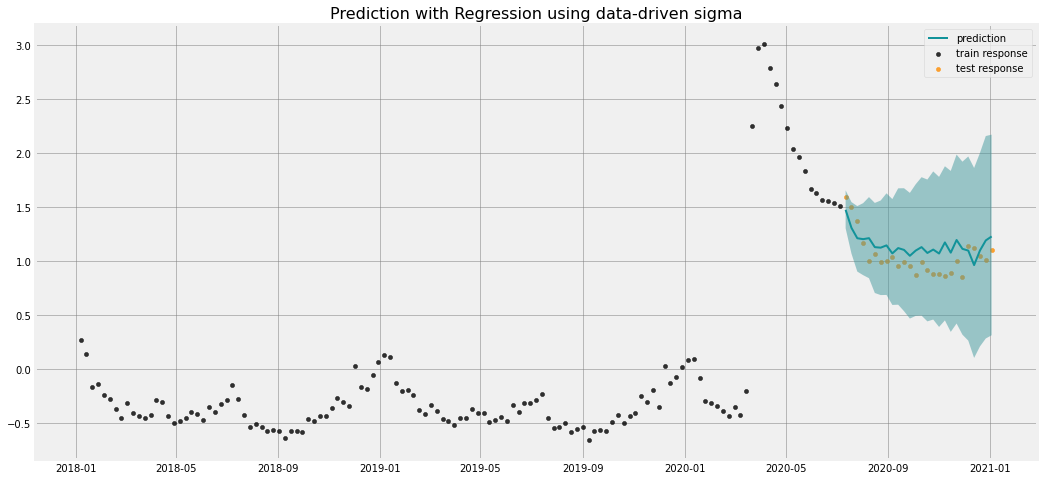

In [108]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_ridge, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using data-driven sigma')

# With Simulated Regression Dataset with Trend

Leverage the simulation function to generate a dateset with regression terms

In [177]:
# To scale regressor values in a nicer way
SEED = 2020
NUM_OF_REGRESSORS = 5
COEFS = np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [178]:
x, y, coefs = make_regression(200, COEFS, seed=SEED)

In [179]:
df = pd.DataFrame(x)
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
df.columns = regressor_cols
#df[regressor_cols] = df[regressor_cols]/REG_BASE
#df[regressor_cols] = df[regressor_cols].apply(np.log1p)

# min max scale to avoid negetive values
response_col = "response"
df[response_col] = y 
df[response_col] = minmax_scale(df[response_col])

# add the date column
df['date'] = pd.date_range(start='2016-01-04', periods=200, freq="1W")

In [180]:
df.head()

,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,response,date
0,0.630103,0.111589,0.000000,-0.709102,-0.136399,0.724856,2016-01-10
1,0.000000,0.125509,0.136342,-0.880252,0.543985,0.535811,2016-01-17
2,-0.000000,0.292064,0.192392,0.000000,0.042711,0.713783,2016-01-24
3,0.666333,-0.000000,-0.240312,-0.408502,0.000000,0.248319,2016-01-31
4,0.593637,-0.256724,-0.000000,0.031756,0.546676,0.440959,2016-02-07


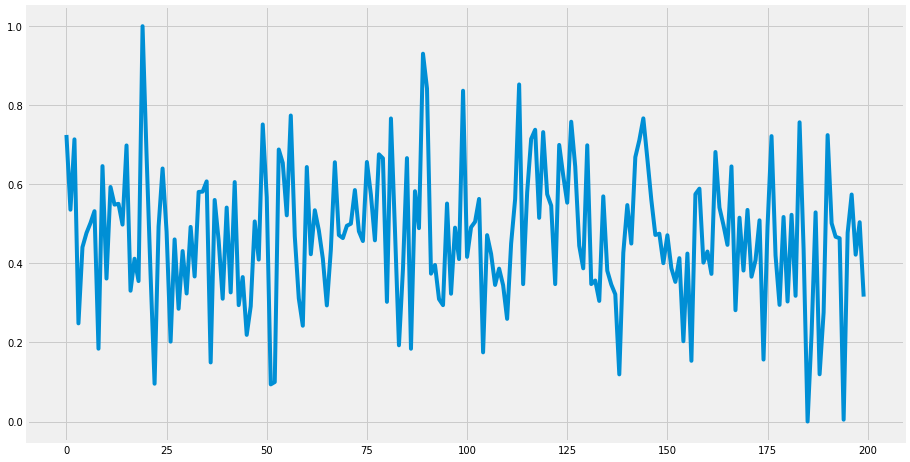

In [181]:
plt.plot(df['response'])

In [182]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9}
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [183]:
mod_fixed_ridge1 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [184]:
mod_fixed_ridge2 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [185]:
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['beta'], axis=0)
coef_fixed_ridge1 = np.median(mod_fixed_ridge1._posterior_samples['beta'], axis=0)
coef_fixed_ridge2 = np.median(mod_fixed_ridge2._posterior_samples['beta'], axis=0)

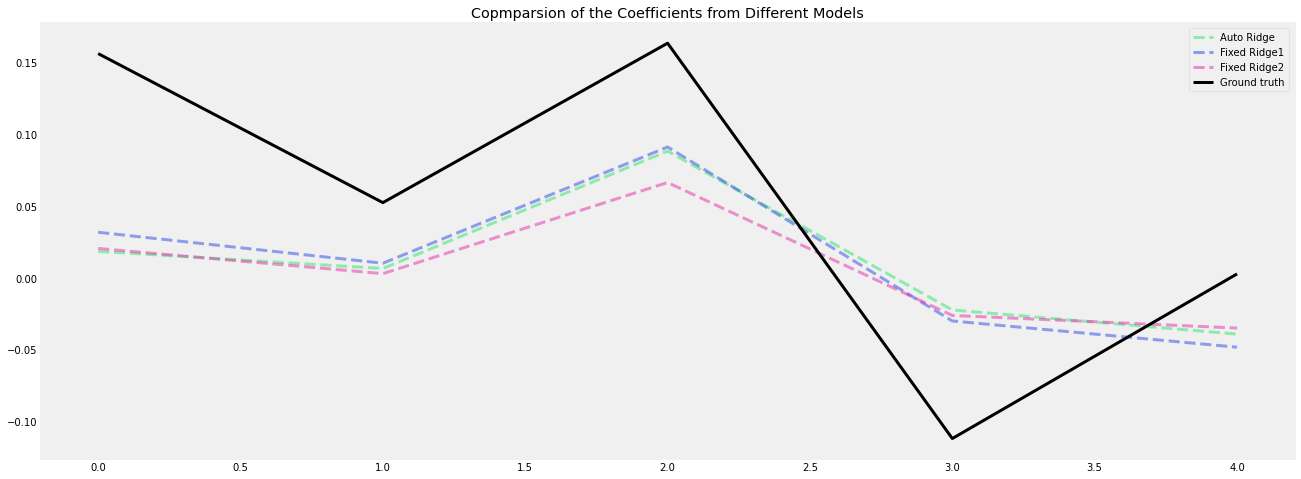

In [186]:
lw = 3
plt.figure(figsize=(20, 8))
plt.title("Copmparsion of the Coefficients from Different Models")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks reasonable comparing to the true coefficients.